# Исследование, определяющее закономерности успешности игр.

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры.  
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Цель:** нужно выявить определяющие успешность игры закономерности. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.  
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. 

# План проекта


* Шаг 1. Файл с данными и изучиение общей информации  
    * Описание данных  
    * Вывод  
* Шаг 2. Подготовка данных  
    * Замена названия столбцов (приведение к нижнему регистру)  
    * Преобразование данных в нужные типы.  
        * year_of_release  
        * user_score  
        * rating  
    * Проверка на дубли  
    * Обработка пропусков  
    * Подсчет суммарных продаж во всех регионах  
    * Вывод  
* Шаг 3. Исследовательский анализ данных  
    * Вывод  
* Шаг 4. Портрет пользователя каждого региона  
    * Портрет пользователя NA  
    * Портрет пользователя EU  
    * Портрет пользователя JP  
    * Вывод  
* Шаг 5. Проверка гипотез  
* Шаг 6. Общий вывод  

## Шаг. Файл с данными и изучиение общей информации

Загрузим файл с данными. Импортируем библиотеки, которые потребуются в работе. Изучим общую информацию по данным.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math as mt
from scipy import stats as st
from scipy.stats import ttest_ind
import scipy.stats
pd.set_option('display.max_columns', None)

In [2]:
# загрузка файла в таблицу df
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# общие данные по таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# доля пропусков в данных
df.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

### Описание данных
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Вывод

Есть пропуски в данных, в столбцах: `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating`.

Всю подготовку данных проведем в следующем шаге. Заменим пропуски, где это будет уместно, изменим название столбцов, приведем к нужному формату данные.

## Шаг. Подготовьте данные

### Замена названия столбцов (приведение к нижнему регистру)



In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование данных в нужные типы. 
Опишим, в каких столбцах заменим тип данных и почему.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### year_of_release

`year_of_release` имеет тип данных float64 и в данном поле есть пропуски, преобразуем тип данных в int. Пропуски в годе выпуска можно удалить 1,6% незначительная потеря данных.

In [8]:
df = df.dropna(subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype('int')
df['year_of_release'].isna().mean()

0.0

`user_score` и `rating` имеют тип данных object, возможно это связано с пропусками, проверим данные поля.

#### user_score

In [9]:
# выведем уникальные значения по полю user_score
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [10]:
print('Кол-во значений tbd:', df[df['user_score'] == 'tbd']['user_score'].count())
print('Доля пропусков nan', df['user_score'].isna().mean())
print('Кол-во значений равные 0:', df[df['user_score'] == '0']['user_score'].count())

Кол-во значений tbd: 2376
Доля пропусков nan 0.40173902468685396
Кол-во значений равные 0: 1


Минимальный бал 0, есть значения nan - пропуски. Значение tbd - аббревиатура To Be Determined, т.е. "Будет определено". Рейтинг равный tbd, говорит о том, что он еще не определен. Nan занимает 40% объема данных. Можно предоположить, что nan = tbd и выполнить замену. Но числовые данные требуется преобразовать из текста в float. Чтобы не навредить заменой данных (т.к. мы достоверно не знаем, почему есть пропуски и зачем используется tbd) заменим tbd на 555, а nan на 999, после чего преобразуем колонку в тип float32.

In [11]:
# заменим nan на tbd
df['user_score'] = df['user_score'].fillna(999)
df['user_score'] = df['user_score'].replace('tbd', 555)
# преобразуем данные в формат float32, чтобы не занимать память
df['user_score'] = df['user_score'].astype('float32')

#### rating

In [12]:
# выведем уникальные значения по полю rating
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

**Классификация рейтинга ESRB:**  
«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.  
«E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет.  
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше».  
«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими.  
«K-A» — Игры с таким рейтингом содержат контент, который, по мнению ESRB, в целом подходит для всех возрастов. Первоначально этот рейтинг был известен как Kids to Adults (KA) до 1998 года; ESRB изначально намеревался использовать «E» для рейтинга, но у другой компании возникли проблемы с товарным знаком из-за использования значка «E».  
«M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.  
«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.  
«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.  

Изменять тип данных не будем. Обработку дублей и пропусков рассмотрим в следующих шагах.

### Проверка на дубли

Проверим наличие явных дублей.

In [13]:
print('Кол-во явных дублей:', df.duplicated().mean())

Кол-во явных дублей: 0.0


Проверим наличие неявных дублей в полях name, platform и genre.

In [14]:
print('Кол-во уникальных названий игр', len(df['name'].unique()))      

Кол-во уникальных названий игр 11427


Всего в таблице 16715 записей, а уникальных названий 11560, скорее всего, одна и та же игра выходила на разных платформах. Проверим нашу догадку.

In [15]:
display(df.groupby('name')['platform'].count().sort_values(ascending=False).head(10))
df.query('name == "Need for Speed: Most Wanted"').sort_values(by=['year_of_release'])

name
Need for Speed: Most Wanted    12
FIFA 14                         9
Ratatouille                     9
LEGO Marvel Super Heroes        9
Cars                            8
LEGO Jurassic World             8
Madden NFL 07                   8
LEGO The Hobbit                 8
Monopoly                        8
FIFA 15                         8
Name: platform, dtype: int64

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E
6473,Need for Speed: Most Wanted,GBA,2005,Racing,0.19,0.07,0.00,0.00,NaN,8.3,E
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,999.0,NaN
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.33,0.45,0.01,0.22,NaN,999.0,NaN


Более того есть игры, которые имеют что-то типа ремикаса, т.е. выходили новые версии без имзменения названий, как получилось с Need for Speed: Most Wanted.  
Дублями это считать нельзя, из 11560 записей затруднительно найти неявные дубли, если они и есть, поэтому ничего исправлять не будем.

In [16]:
# выведем уникальные значения по полю platform
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Неявных дублей нет.  
Проверим поле genre.

In [17]:
# выведем уникальные значения по полю genre
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

Ранее в поле rating находили неявные дубли, например E и K-A, перезапишем K-A на E. RP перезаписывать не будем на unknown, т.к. заявка все-таки на присвоение категории была подана.

In [18]:
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'M', 'RP', 'T', nan], dtype=object)

Дубли обнаружены не были.

### Обработка пропусков

Объясним, почему заполнили пропуски определённым образом или почему не стали этого делать. Опишим причины, которые могли привести к пропускам.

В поле rating есть значения NaN, так же можно предположить, что nan = «RP», «Рейтинг ожидается».
Организация ESRB появилась в 1994 году. За первые 10 лет работы рейтинги ESRB были присвоены более 8000 программных продуктов от 350 издателей, а в 2006 году оценку прошло 1285 игр. Возможно, что по играм с year_of_release до 1994 включительно и должны стоять NaN. Посмотрим пропуски от 1994 года.

In [19]:
print('Доля пропусков в поле rating до 1994 года:', df.query('year_of_release < 1994')['rating'].isna().mean())
print('Доля пропусков в поле rating от 1994 года:', df.query('year_of_release >= 1994')['rating'].isna().mean())

Доля пропусков в поле rating до 1994 года: 0.989100817438692
Доля пропусков в поле rating от 1994 года: 0.39274830524286336


Обычно этот рейтинг никто не хочет получить, так как велика вероятность, что игра вообще не окупится. Причины тому, что три основных производителя консолей [Nintendo, Sony и Microsoft] не разрешают выпускать игры с рейтингом AO на своих системах, как и большинство розничных магазинов. Поэтому и есть пропуски. Заменим их на unknown.

In [20]:
df['rating'] = df['rating'].fillna('unknown')

Пропуски в полях `name и genre` мы заменим на unknown, чтобы не потерять из анализа.  
В поле `critic_score` пропущенные значения заменим на 999, как поступили с полем user_score, если в дальнейшем мы будем использовать группировки по этим полям и не заменим пропущенные значения, то такие строки не будут учтены.

In [21]:
df['name'] = df['name'].fillna('unknown')
df['genre'] = df['genre'].fillna('unknown')
df['critic_score'] = df['critic_score'].fillna(999)   

In [22]:
# выведем доли пропусков по каждому полю, для проверки
df.isna().mean()

name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
critic_score       0.0
user_score         0.0
rating             0.0
dtype: float64

### Подсчет суммарных продаж во всех регионах 

Запишим их в отдельный столбец.

In [23]:
df['all_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [24]:
# выведем топ-5 самых продаваемых игр за весь период
df.groupby(['name', 'year_of_release'])['all_sales'].sum().sort_values(ascending=False).head(5)

name                year_of_release
Wii Sports          2006               82.54
Super Mario Bros.   1985               40.24
Grand Theft Auto V  2013               37.32
Mario Kart Wii      2008               35.52
Wii Sports Resort   2009               32.77
Name: all_sales, dtype: float64

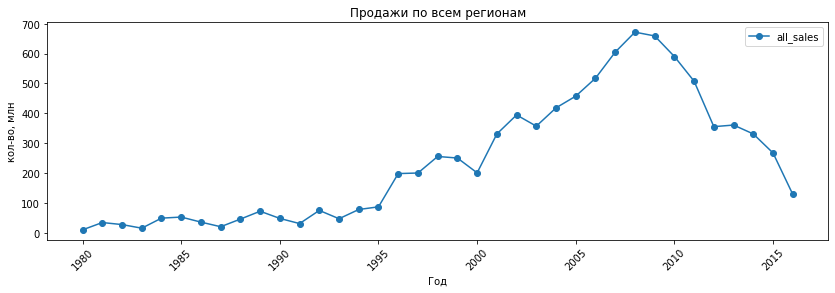

In [25]:
(df
 .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
 .plot(kind='line', figsize=(14,4),  style = 'o-', rot=45)
)
plt.title('Продажи по всем регионам')
plt.xlabel('Год')
plt.ylabel('кол-во, млн');

Пик продаж пришелся на 2008 год. Выведем топ игр за этот год.

In [26]:
(df.query('year_of_release == 2008')).groupby('name')['all_sales'].sum().sort_values(ascending=False).head(10)

name
Mario Kart Wii                                 35.52
Grand Theft Auto IV                            22.37
Call of Duty: World at War                     15.78
Super Smash Bros. Brawl                        12.84
Star Wars: The Force Unleashed                 10.02
Guitar Hero: World Tour                        10.00
Fallout 3                                       9.85
LEGO Indiana Jones: The Original Adventures     9.57
LEGO Batman: The Videogame                      9.06
FIFA Soccer 09                                  8.66
Name: all_sales, dtype: float64

### Вывод

Поле year_of_release имел тип данных float64, преобразовали в тип datetime64.  

Поле user_score имеет минимальный бал 0. Значение равные tbd - аббревиатура To Be Determined, т.е. "Будет определено". Рейтинг равный tbd, говорит о том, что он еще не определен. Nan занимает 40% объема данных. Числовые данные требовалось преобразовать из текста в float. Чтобы не навредить заменой пропущенных данных (т.к. мы достоверно не знаем, почему есть пропуски и зачем используется tbd) заменили tbd на 555, а nan на 999, после чего преобразовали колонку в тип float32.

Явных и неявных дублей обнаружено не было.  

В поле rating есть значения NaN, так же можно предположить, что nan = «RP», «Рейтинг ожидается». Но организация ESRB появилась в 1994 году и игры появившиеся до 1994 не имеют рейтинга. Обычно этот рейтинг никто не хочет получить, так как велика вероятность, что игра вообще не окупится. Причины тому, что три основных производителя консолей [Nintendo, Sony и Microsoft] не разрешают выпускать игры с рейтингом AO на своих системах, как и большинство розничных магазинов. Поэтому и есть пропуски.  
Пропуски в `year_of_release и genre` мы заменить не смогли, т.к. требуется ручная обработка.  
В поле `critic_score` пропущенные значения заменили на 999, как поступили с полем user_score, если в дальнейшем мы будем использовать группировки по этим полям и не заменим пропущенные значения, то такие строки не будут учтены.

Пик продаж пришелся на 2008 год.

## Шаг. Исследовательский анализ данных
Посмотрим, сколько игр выпускалось в разные годы.

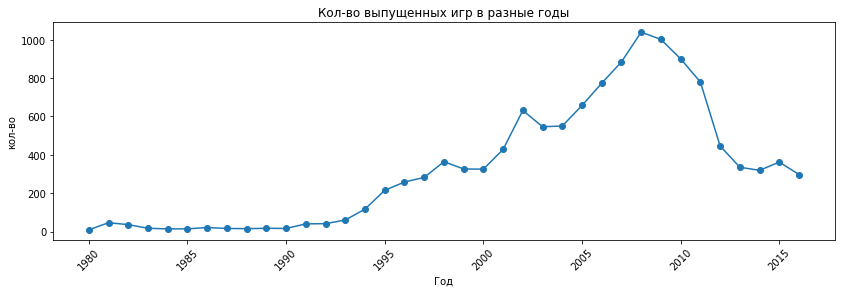

In [27]:
df.groupby('year_of_release')['name'].nunique().plot(kind='line', figsize=(14,4),  style = 'o-', rot=45)
plt.title('Кол-во выпущенных игр в разные годы')
plt.xlabel('Год')
plt.ylabel('кол-во');

Пик выпуска игр пришелся на 2008 год. Рост производства игр начался с 1994 года

Выберем платформы с наибольшими суммарными продажами и посмотрим, как менялись продажи по платформам. 

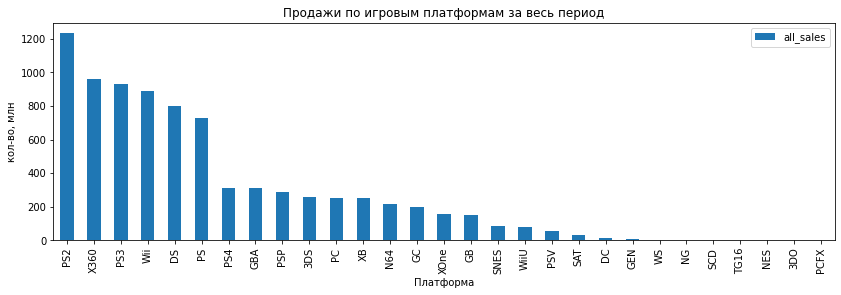

In [28]:
(df.query('year_of_release >= 1994').pivot_table(index='platform', values='all_sales', aggfunc='sum')
 .sort_values(by='all_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым платформам за весь период')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

В топ попали 6 игровых платформ:

In [29]:
# выведем сводную по 6 игровым платформам, которые попали в топ
top_platform = (df.pivot_table(index='platform', values=['year_of_release', 'all_sales']
                               , aggfunc={'year_of_release': [np.min, np.max]
                                          , 'all_sales': [np.sum, np.max, np.mean]})
 .sort_values(by=('all_sales',  'sum'), ascending=False)
 .reset_index()              

)
# переименуем колонки в понятные названия
top_platform.columns = ['platform', 'max_sales', 'mean_sales', 'sum_sales', 'years_last', 'years_first']
# длительность использования платформы
top_platform['time_span'] = top_platform['years_last'] - top_platform['years_first']
top_platform.head(6)

,platform,max_sales,mean_sales,sum_sales,years_last,years_first,time_span
0,PS2,20.81,0.579953,1233.56,2011,2000,11
1,X360,21.82,0.780227,961.24,2016,2005,11
2,PS3,21.05,0.713124,931.34,2016,2006,10
3,Wii,82.54,0.692986,891.18,2016,2006,10
4,DS,29.80,0.378491,802.78,2013,1985,28
5,PS,10.95,0.611412,727.58,2003,1994,9


В среднем платформа держится на рынке 10-11 лет. Даже DS имеет рост продаж начиная с 2004 года и можно более ранние периоды не рассматривать.

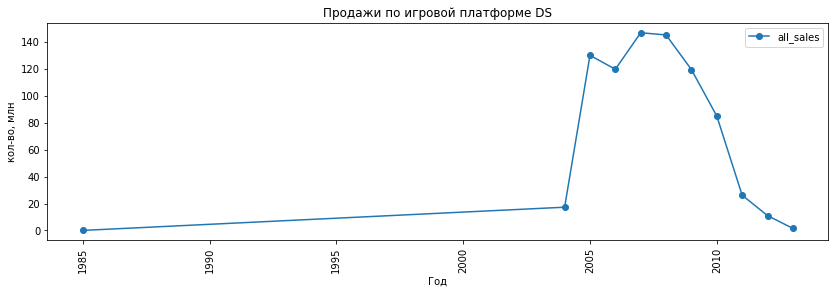

In [30]:
# выведем график только по платформе DS
(df.query('platform == "DS"')
 .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
 .sort_values(by='year_of_release')
 .plot(kind='line', style='-o', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровой платформе DS')
plt.xlabel('Год')
plt.ylabel('кол-во, млн');

In [31]:
# проверим выброс по 1985 году
df.query('platform == "DS" and year_of_release < 2004')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,999.0,999.0,unknown,0.02


Игра на самом деле была выпущена в 2010 году, данные некорректные по записи из таблицы. [Здесь информация по игре](https://www.vgchartz.com/game/4399/strongest-tokyo-university-shogi-ds/)

Построим распределение по годам по всем платформам попавших в топ-6.

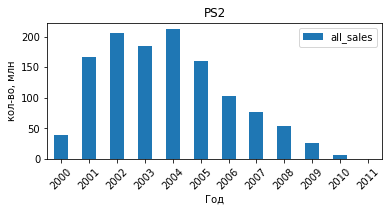

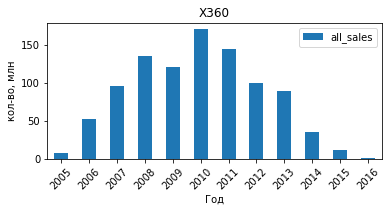

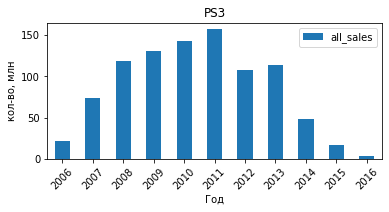

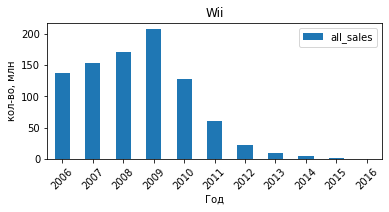

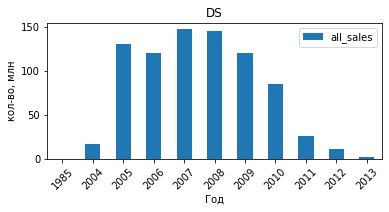

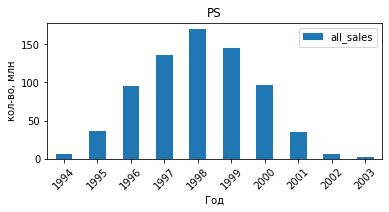

In [32]:
# напишем цикл, который выведет все графики
for p in top_platform['platform'].head(6):
    (df.query('platform == @p')
     .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
     .sort_values(by='year_of_release')
     .plot(kind='bar', style='-o', figsize=(6,2.5), rot=45)
    )
    plt.title(p)
    plt.xlabel('Год')
    plt.ylabel('кол-во, млн');    

Возьмем данные за период с 2013 по 2016 включительно. Актуальный период определили в результате исследования предыдущих вопросов, основной фактор — эти данные помогут построить прогноз на 2017 год. Учитывать в работе данные за предыдущие годы не будем.

In [33]:
df_query = df.query('2013 <= year_of_release <= 2016').copy()
df_query.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,999.0,999.0,unknown,14.63


Проанализируем лидирующие платформы по продажам, проверим как ведет себя тренд продаж, растет или падает.

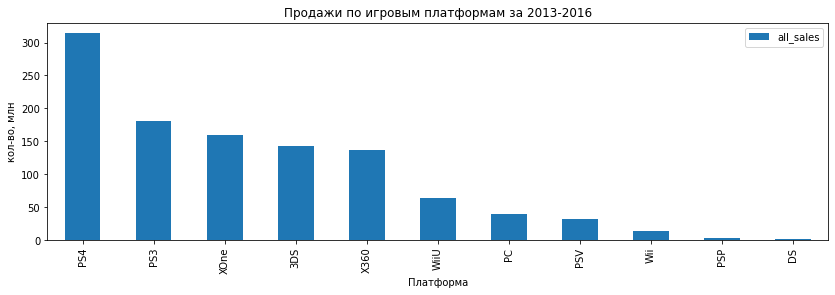

In [34]:
(df_query.pivot_table(index='platform', values='all_sales', aggfunc='sum')
 .sort_values(by='all_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым платформам за 2013-2016')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

# Выполним категоризацию игровых платформ, например: PS3 и PS4 это PlayStation.

In [35]:
# напишем функцию для создания категории
def category_platform(row):
    if row['platform'] in ['PS4', 'PS3', 'PSV', 'PSP']:
        return 'PlayStation'
    if row['platform'] in ['DS', '3DS', 'Wii', 'WiiU']:
        return 'Nintendo'
    if row['platform'] in ['X360', 'XOne']:
        return 'Xbox'
    else:
        return 'other'
df_query['category_platform'] = df_query.apply(category_platform, axis=1)
df_query.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,category_platform
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,PlayStation
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,Xbox
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,999.0,999.0,unknown,14.63,PlayStation


Выведем 2 графика продаж за анлизируемый период в различных видах.

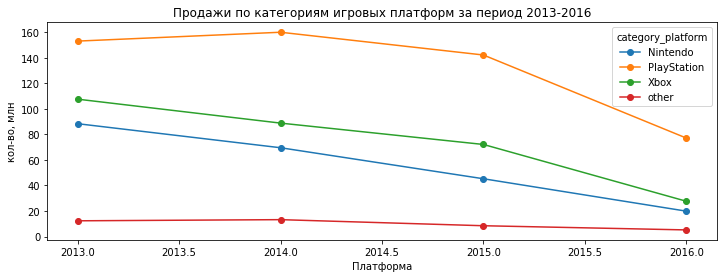

In [77]:
# построим график продаж в разрезе категорий
(df_query.pivot_table(index='category_platform', columns='year_of_release', values='all_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=0)
)
plt.title('Продажи по категориям игровых платформ за период 2013-2016')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

**Ниже выведено 2 тепловые карты, одна по категории PlayStation показывает суммарные продажи по каждому году без деления на платфоры, вторая тепловая карта показывает суммарные продажи по каждой платформе. И из второй видно что продажи PS3 падают, а PS4 растут (искл.2016).**

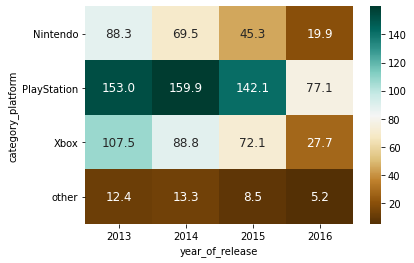

In [37]:
# так же выведем тепловую карту продаж в разрезе категорий
sns.heatmap(df_query.pivot_table(index='category_platform', columns='year_of_release'
                                 , values='all_sales', aggfunc='sum'), cmap='BrBG'
            , annot_kws={"size": 12}, annot=True, fmt='.1f');

Продажи в целом с 2009 года пошли на убыль, и в анализируемом периоде так же идет спад продаж.
Потенциально прибыльными платформами являются PlayStation (PS4), Xbox (XOne) и Nintendo (3DS).  

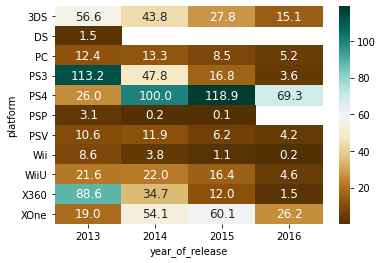

In [38]:
# так же выведем тепловую карту продаж в разрезе всех платформ
sns.heatmap(df_query.pivot_table(index='platform', columns='year_of_release'
                                 , values='all_sales', aggfunc='sum'), cmap='BrBG'
            , annot_kws={"size": 12}, annot=True, fmt='.1f');

# Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам  PlayStation (PS4), Xbox (XOne) и Nintendo (3DS).

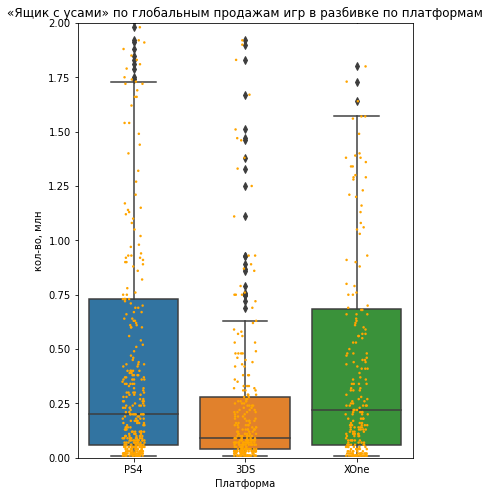

In [39]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x='platform', y='all_sales', data=df_query.query('platform in ["PS4", "XOne", "3DS"]'))
# add stripplot
ax = sns.stripplot(x='platform', y='all_sales', data=df_query.query('platform in ["PS4", "XOne", "3DS"]')
                   , color="orange", jitter=1, size=2.5)
plt.title('«Ящик с усами» по глобальным продажам игр в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн')
plt.ylim([0, 2]);

# Проверим, как влияют на продажи внутри одной популярной платформы (PS4) отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

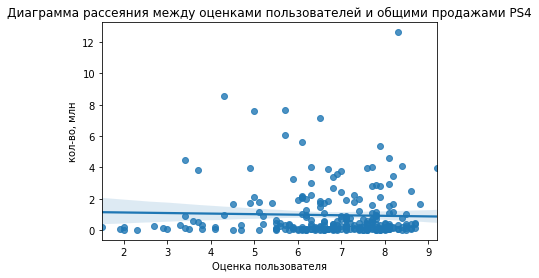

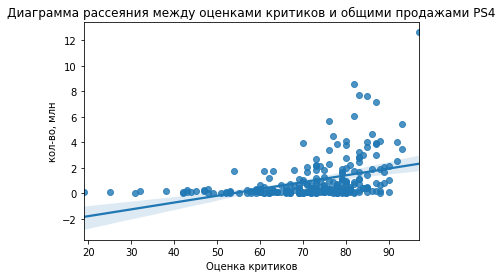

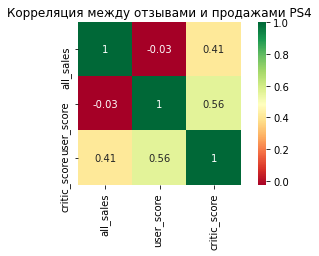

In [78]:
sns.regplot(x='user_score', y='all_sales', data=df_query.query('platform == "PS4" and user_score < 555'))
plt.title('Диаграмма рассеяния между оценками пользователей и общими продажами PS4')
plt.xlabel('Оценка пользователя')
plt.ylabel('кол-во, млн')
plt.show();
sns.regplot(x='critic_score', y='all_sales', data=df_query.query('platform == "PS4" and critic_score < 999'));
plt.title('Диаграмма рассеяния между оценками критиков и общими продажами PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('кол-во, млн');

plt.figure(figsize=(6, 3))
(sns.heatmap(
    (df_query
     .query('platform == "PS4" and (critic_score < 999 and user_score < 555)')[['all_sales', 'user_score', 'critic_score']]
     .corr().round(2)
    )
    , annot=True
    , cmap='RdYlGn'
    , square=True)
)
plt.title('Корреляция между отзывами и продажами PS4')
plt.show();

Оценки критиков, если и оказывают влияние на объем продаж PS4, то оно слишком мало. Мы не принимаем в расчет показатель коэф. корреляции от -0,5 до +0,5, т.к. данные значения показывают слабую линейную зависимость. При этом оценки пользователей совсем не оказывают влияние на объем продаж платформы.  

Построим аналогичные графики по другим платформам без PS4.

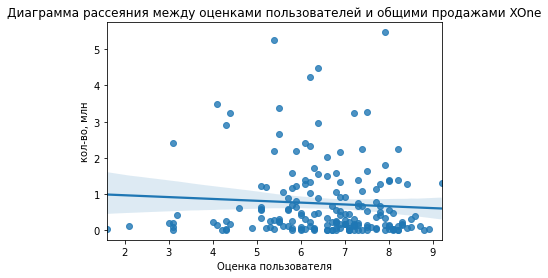

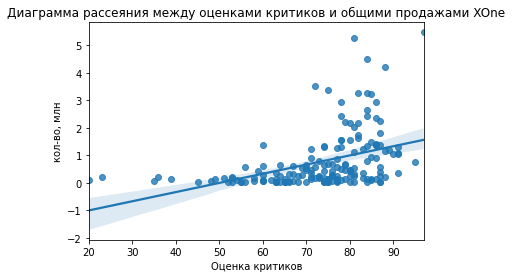

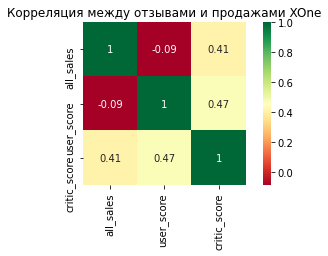

In [79]:
sns.regplot(x='user_score', y='all_sales', data=df_query.query('platform == "XOne" and user_score < 555'))
plt.title('Диаграмма рассеяния между оценками пользователей и общими продажами XOne')
plt.xlabel('Оценка пользователя')
plt.ylabel('кол-во, млн')
plt.show();
sns.regplot(x='critic_score', y='all_sales', data=df_query.query('platform == "XOne" and critic_score < 999'));
plt.title('Диаграмма рассеяния между оценками критиков и общими продажами XOne')
plt.xlabel('Оценка критиков')
plt.ylabel('кол-во, млн');

plt.figure(figsize=(6, 3))
(sns.heatmap(
    (df_query
     .query('platform == "XOne" and (critic_score < 999 and user_score < 555)')[['all_sales', 'user_score', 'critic_score']]
     .corr().round(2)
    )
    , annot=True
    , cmap='RdYlGn'
    , square=True)
)
plt.title('Корреляция между отзывами и продажами XOne')
plt.show();

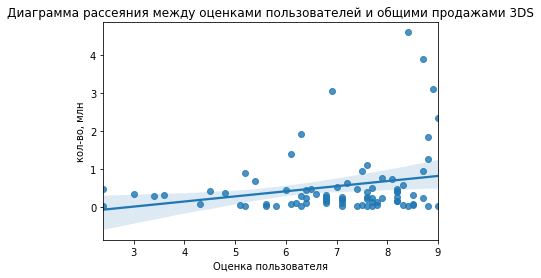

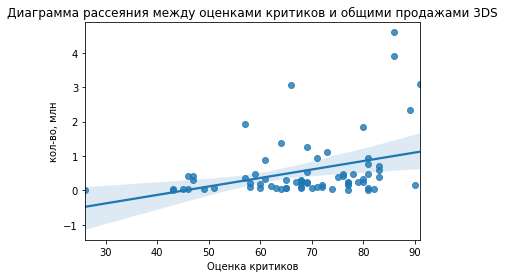

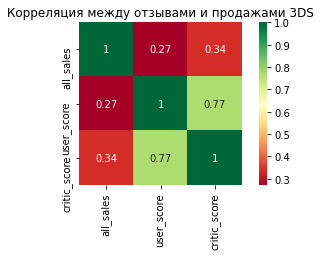

In [80]:
sns.regplot(x='user_score', y='all_sales', data=df_query.query('platform == "3DS" and user_score < 555'))
plt.title('Диаграмма рассеяния между оценками пользователей и общими продажами 3DS')
plt.xlabel('Оценка пользователя')
plt.ylabel('кол-во, млн')
plt.show();
sns.regplot(x='critic_score', y='all_sales', data=df_query.query('platform == "3DS" and critic_score < 999'));
plt.title('Диаграмма рассеяния между оценками критиков и общими продажами 3DS')
plt.xlabel('Оценка критиков')
plt.ylabel('кол-во, млн');

plt.figure(figsize=(6, 3))
(sns.heatmap(
    (df_query
     .query('platform == "3DS" and (critic_score < 999 and user_score < 555)')[['all_sales', 'user_score', 'critic_score']]
     .corr().round(2)
    )
    , annot=True
    , cmap='RdYlGn'
    , square=True)
)
plt.title('Корреляция между отзывами и продажами 3DS')
plt.show();

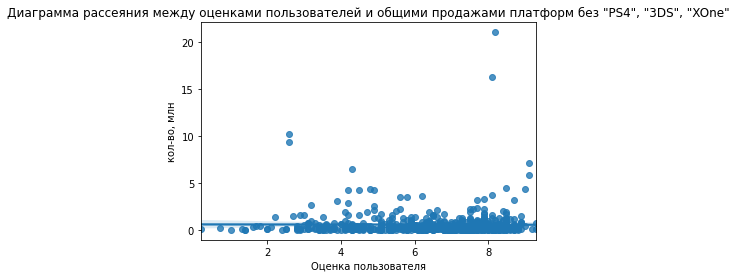

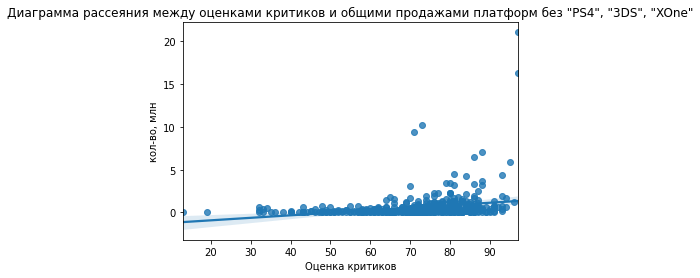

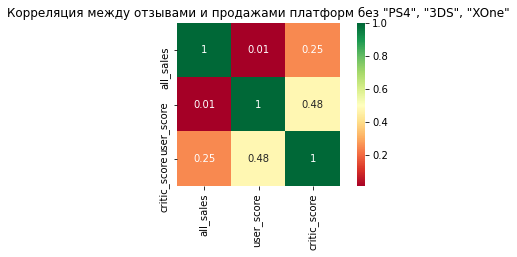

In [81]:
sns.regplot(x='user_score', y='all_sales', data=df_query.query('platform not in ["PS4", "3DS", "XOne"] and user_score < 555'))
plt.title('Диаграмма рассеяния между оценками пользователей и общими продажами платформ без "PS4", "3DS", "XOne"')
plt.xlabel('Оценка пользователя')
plt.ylabel('кол-во, млн')
plt.show();
sns.regplot(x='critic_score', y='all_sales', data=df_query
            .query('platform not in ["PS4", "3DS", "XOne"] and critic_score < 999'));
plt.title('Диаграмма рассеяния между оценками критиков и общими продажами платформ без "PS4", "3DS", "XOne"')
plt.xlabel('Оценка критиков')
plt.ylabel('кол-во, млн');

plt.figure(figsize=(6, 3))
(sns.heatmap(
    (df_query
     .query('platform not in ["PS4", "3DS", "XOne"] and (critic_score < 999 and user_score < 555)')
     [['all_sales', 'user_score', 'critic_score']]
     .corr().round(2)
    )
    , annot=True
    , cmap='RdYlGn'
    , square=True)
)
plt.title('Корреляция между отзывами и продажами платформ без "PS4", "3DS", "XOne"')
plt.show();

Оценки критиков, если и оказывают влияние на объем продаж, то оно слишком мало. Мы не принимаем в расчет показатель коэф. корреляции от -0,5 до +0,5, т.к. данные значения показывают слабую линейную зависимость. При этом оценки пользователей совсем не оказывают влияние на продажи.  
В обоих срезах имеется очень слабая зависимость оценок критиков и объема продаж, которую во внимание мы не принимаем.

# Рассмотрим общее распределение игр по жанрам. Выделим самые прибыльные жанры.

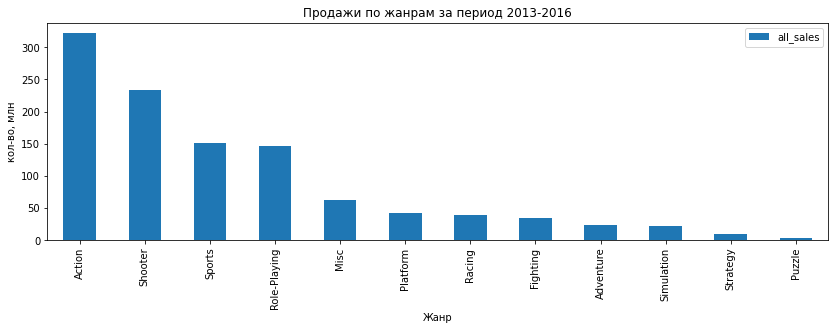

In [44]:
(df_query.pivot_table(index='genre', values='all_sales', aggfunc='sum')
 .sort_values(by='all_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по жанрам за период 2013-2016')
plt.xlabel('Жанр')
plt.ylabel('кол-во, млн');

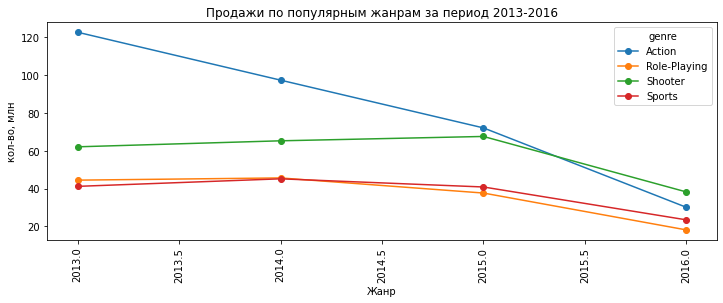

In [45]:
# построим график продаж в разрезе самых популярных жанров
(df_query.pivot_table(index=df_query.query('genre in ["Action", "Shooter", "Sports", "Role-Playing"]')['genre']
                      , columns='year_of_release', values='all_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по популярным жанрам за период 2013-2016')
plt.xlabel('Жанр')
plt.ylabel('кол-во, млн');

Стоит проанализировать прибыльность жанров на диаграмме размаха, сравнить медианные продажи на каждом жанре и проверить какая из них более стабильна и имеет более длинный ряд успешно продающихся игр.

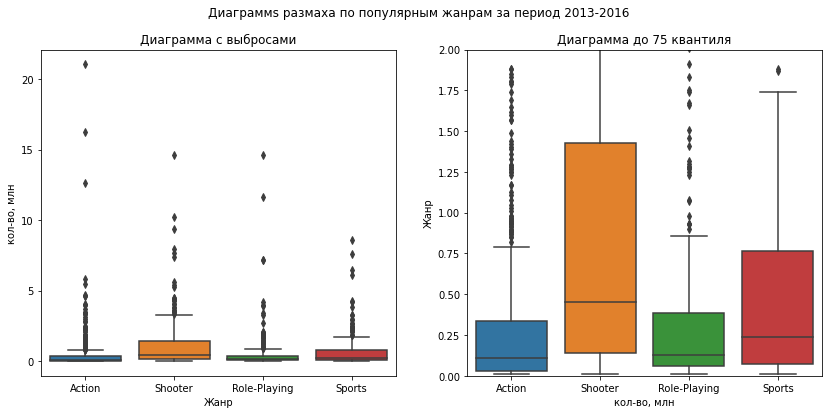

In [82]:
plt.figure(figsize=(14,6))
plt.suptitle('Диаграммs размаха по популярным жанрам за период 2013-2016')
plt.subplot(121)
sns.boxplot(x='genre', y='all_sales', data=df_query
            .query('genre in ["Action", "Shooter", "Sports", "Role-Playing"]')[['genre', 'year_of_release', 'all_sales']])
plt.title('Диаграмма с выбросами')
plt.xlabel('Жанр')
plt.ylabel('кол-во, млн');

plt.subplot(122)
sns.boxplot(x='genre', y='all_sales', data=df_query
            .query('genre in ["Action", "Shooter", "Sports", "Role-Playing"]')[['genre', 'year_of_release', 'all_sales']])
plt.title('Диаграмма до 75 квантиля')
plt.xlabel('кол-во, млн')
plt.ylabel('Жанр')
plt.ylim([0, 2]);

Объем продаж игр в жанре Shooter выше и стабильнее. Можно сказать, что интерес пользователи больше будут проявлять к Shooter-играм и данный жанр выйдет в лидеры продаж, не мтоит упускать из виду и игры жанра Sports.

### Вывод

Пик выпуска игр пришелся на 2008 год, далее наблюдается спад продаж. Рост производства игр начался с 1994 года.  
Популярностью пользуются 6 игровых платформ от компаний PlayStation, Xbox и Nintendo. В среднем платформа держится на рынке 10-11 лет.  
Продажи в целом с 2009 года пошли на убыль, и в анализируемом периоде так же идет спад продаж. Потенциально прибыльными платформами являются PlayStation (PS4), Xbox (XOne) и Nintendo (3DS).  
Оценки критиков, если и оказывают влияние на объем продаж PS4, то оно слишком мало. Мы не принимаем в расчет показатель коэф. корреляции от -0,5 до +0,5, т.к. данные значения показывают слабую линейную зависимость. При этом оценки пользователей совсем не оказывают влияние на объем продаж платформы. Такая же корреляция и по срезу с остальными платформаими. 
Объем продаж игр в жанре Shooter выше и стабильнее. Можно сказать, что интерес пользователи больше будут проявлять к Shooter-играм и данный жанр выйдет в лидеры продаж, не мтоит упускать из виду и игры жанра Sports.
Shooter-ы на платформах PlayStation предположительно будут пользоваться спросом в 2017. Учитывая, что платформа в среднем на рынке живет 10 лет, а PS4 появилась в 2013, то немаловероятно, что она просуществует до 2023 года и пик продаж по этой платформе как раз придется на 2017 год.
Данные за 2016 год неполные, и в 2016 году был спад объемов продаж.

## Шаг 4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишим различия в долях продаж.
* Самые популярные жанры (топ-5). Поясним разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе.


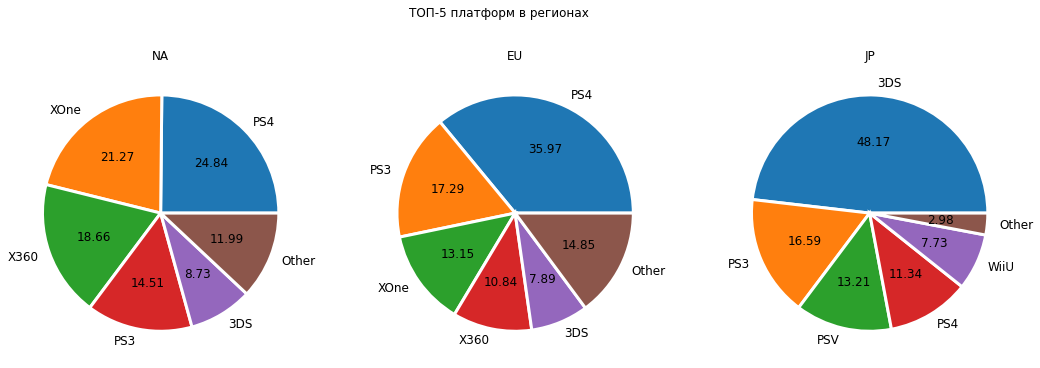

In [83]:
# задаем список регионов
countries = df_query.columns[4:7]
# начертим круговую диаграмму для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('ТОП-5 платформ в регионах')
for i in range(3):
    # выберем 5 самых продающих платформ
    df_i = (df_query.groupby('platform')[countries[i]].sum().
               reset_index().
               sort_values(countries[i], ascending = False, ignore_index = True).
               head(5))
    # занесем все остальыне продажи в Other_platforms
    df_i = (df_i.append({'platform': 'Other', countries[i]: df_query[countries[i]].sum() 
                         - df_i[countries[i]].sum()}, ignore_index= True)
           )
      
    axs[i].pie(df_i[countries[i]], labels = df_i['platform'], autopct='%.2f',
         wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
         textprops={'size': 'large'})
    # Зададим название региона.
    axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

### Портрет пользователя NA

Отразим cамые популярные платформы в Северной Америке через график.

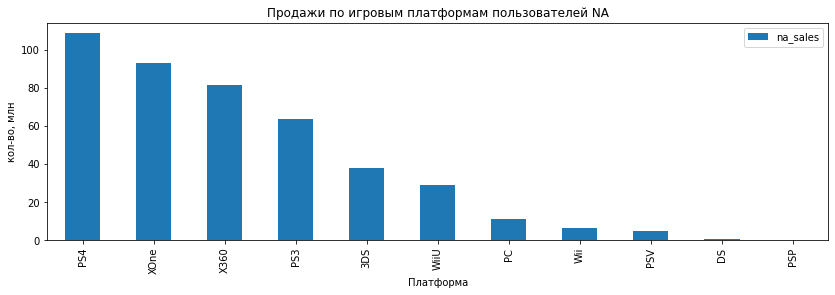

In [47]:
(df_query.pivot_table(index='platform', values='na_sales', aggfunc='sum')
 .sort_values(by='na_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым платформам пользователей NA')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

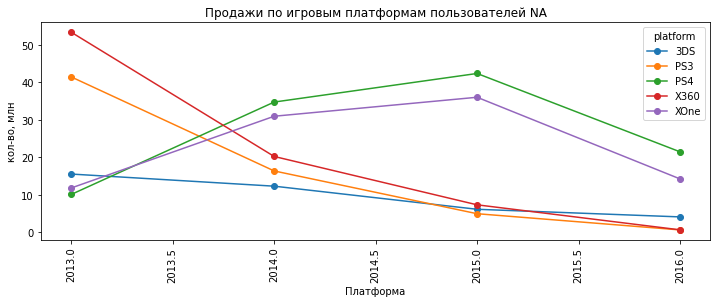

In [48]:
# построим график продаж в разрезе самых популярных платформ
(df_query.pivot_table(index=df_query.query('platform in ["PS4", "XOne", "X360", "PS3", "3DS"]')['platform']
                      , columns='year_of_release', values='na_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по игровым платформам пользователей NA')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

В топ-5 попали платформы PS4, XOne, X360, PS3 и 3DS.

Отразим cамые популярные жанры игр в Северной Америке через график.

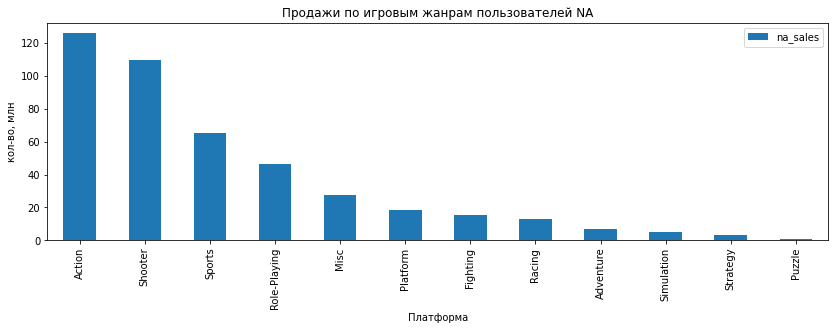

In [49]:
(df_query.pivot_table(index='genre', values='na_sales', aggfunc='sum')
 .sort_values(by='na_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым жанрам пользователей NA')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

В топ попали те же жанры, что и в общем анализе данных Action, Shooter, Sports, Role-Playing, Misc.

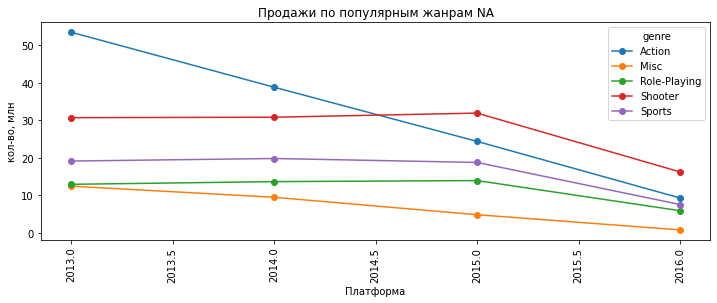

In [50]:
# построим график продаж в разрезе самых популярных жанров
(df_query.pivot_table(index=df_query.query('genre in ["Action", "Shooter", "Sports", "Role-Playing", "Misc"]')['genre']
                      , columns='year_of_release', values='na_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по популярным жанрам NA')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Жанр Shooter так же начинает пользоваться большей популярностью среди пользователей Северной Америки. Наблюдался незначительный рост по продажам жанра Role-Playing в 2015.

Отразим продажи исходя из рейтинга ESRB в Северной Америке через график.

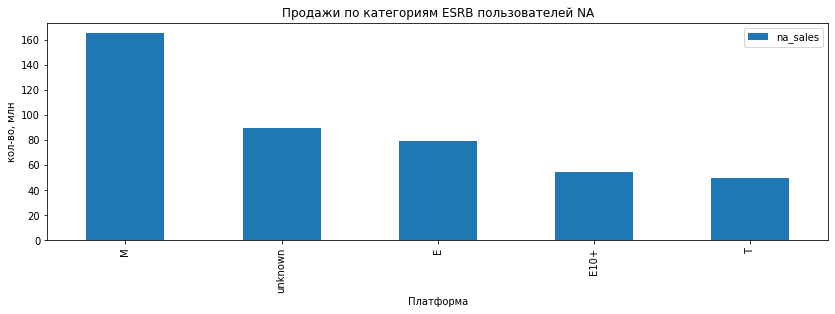

In [51]:
(df_query.pivot_table(index='rating', values='na_sales', aggfunc='sum')
 .sort_values(by='na_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по категориям ESRB пользователей NA')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Доля продаж выше у категорий игр "Для взрослых", на втором месте игры без рейтинга.

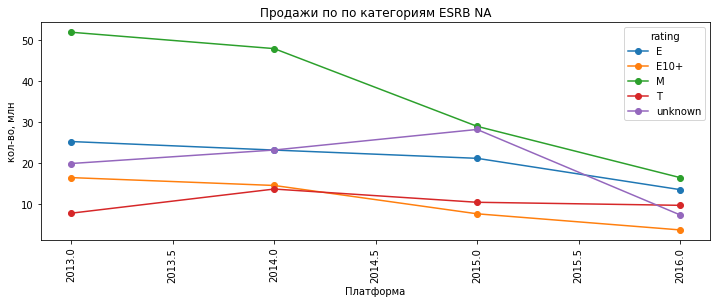

In [52]:
# построим график продаж в разрезе rating
(df_query.pivot_table(index='rating'
                      , columns='year_of_release', values='eu_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по по категориям ESRB NA')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Поведение в 2016 году меняется, есть резкое снижение спроса на категорию игр "Для взрослых" и для игр, у которых не определена категория.

### Портрет пользователя EU

Отразим cамые популярные платформы в Европе через график.

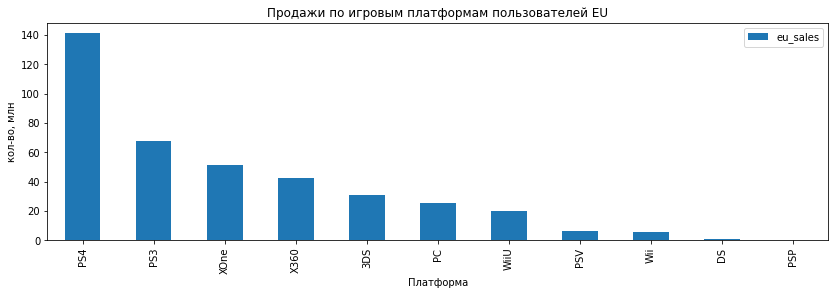

In [54]:
(df_query.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
 .sort_values(by='eu_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым платформам пользователей EU')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

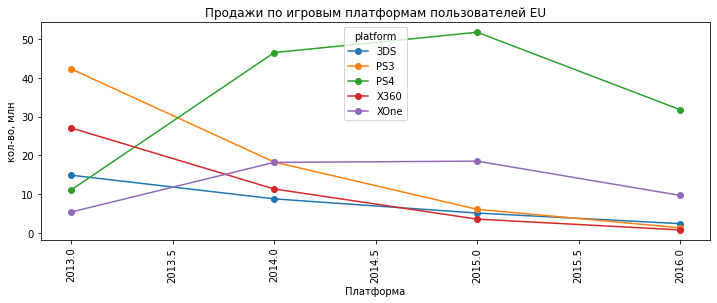

In [55]:
# построим график продаж в разрезе самых популярных платформ
(df_query.pivot_table(index=df_query.query('platform in ["PS4", "PS3", "XOne", "X360", "3DS"]')['platform']
                      , columns='year_of_release', values='eu_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по игровым платформам пользователей EU')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

В топ-5 попали платформы PS4 и XOne они имеют более стабильные продажи, учитывая, что продажи в 2016 году на игры снизились, так же в топе PS3, X360 и 3DS с нисходящим трендом.

Отразим cамые популярные жанры игр в Европе через график.

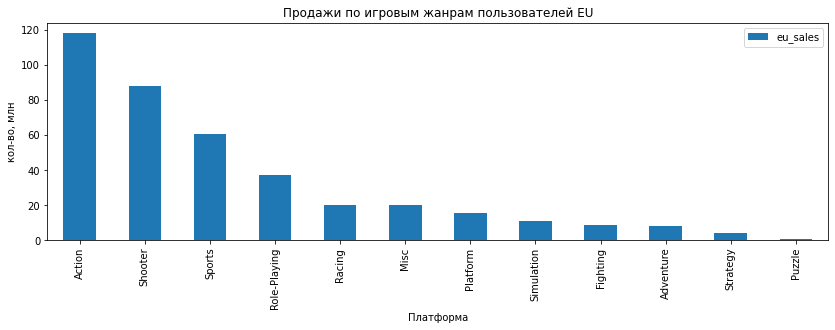

In [56]:
(df_query.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
 .sort_values(by='eu_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым жанрам пользователей EU')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

В топ попали те же жанры, что и в общем анализе данных Action, Shooter, Sports, Role-Playing, Racing. На пятом месте по вкусовым предпочтениям Европейцев есть отличие.

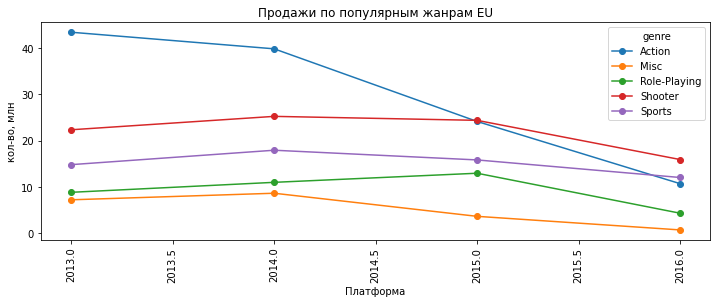

In [57]:
# построим график продаж в разрезе самых популярных жанров
(df_query.pivot_table(index=df_query.query('genre in ["Action", "Shooter", "Sports", "Role-Playing", "Misc"]')['genre']
                      , columns='year_of_release', values='eu_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по популярным жанрам EU')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Жанр Shooter так же начинает пользоваться большей популярностью среди пользователей Европы, более того в 2016 году набирает популярность жанр Sports.

Отразим продажи исходя из рейтинга ESRB в Европе через график.

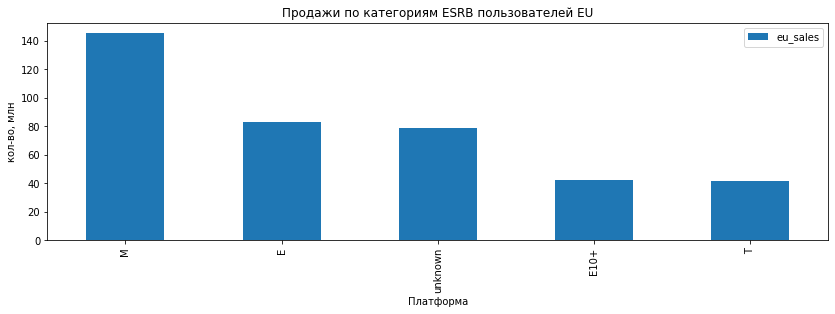

In [58]:
(df_query.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
 .sort_values(by='eu_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по категориям ESRB пользователей EU')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Доля продаж выше у категорий игр "Для взрослых", на втором месте игры c категрией для всех.

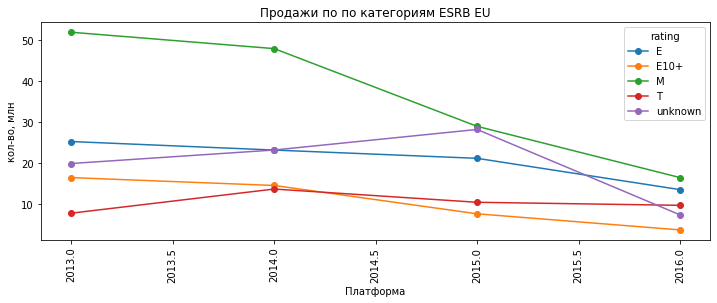

In [59]:
# построим график продаж в разрезе самых популярных жанров
(df_query.pivot_table(index='rating'
                      , columns='year_of_release', values='eu_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по по категориям ESRB EU')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Спрос на игры категории "Для подростков" (T) занимает более стабильные позиции, остальные категории игр теряют в объеме продаж.

### Портрет пользователя JP

Отразим cамые популярные платформы в Японии через график.

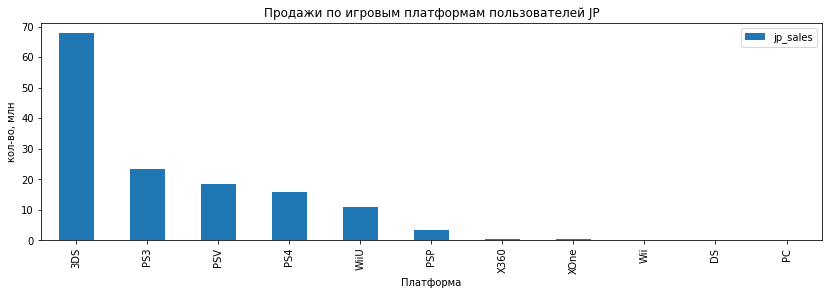

In [60]:
(df_query.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
 .sort_values(by='jp_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым платформам пользователей JP')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

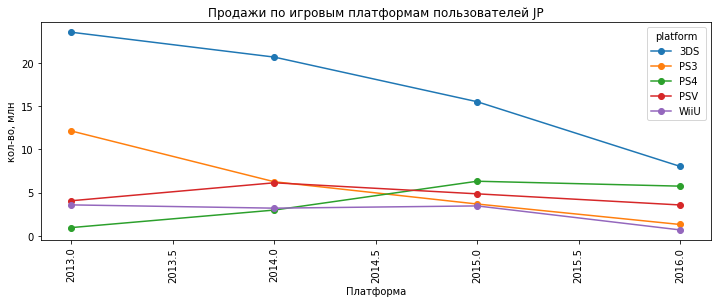

In [61]:
# построим график продаж в разрезе самых популярных платформ
(df_query.pivot_table(index=df_query.query('platform in ["3DS", "PS3", "PSV", "PS4", "WiiU"]')['platform']
                      , columns='year_of_release', values='jp_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по игровым платформам пользователей JP')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

В топ-5 попали платформы 3DS (с большим отрывом), PS3, PSV, PS4 и WiiU. Топ платформ в Японии разительно отличается от Европы и Северной Америки. При этом тренд нисходящий у 3DS, наблюдается рост продаж на платформе PS4.

Отразим cамые популярные жанры игр в Европе через график.

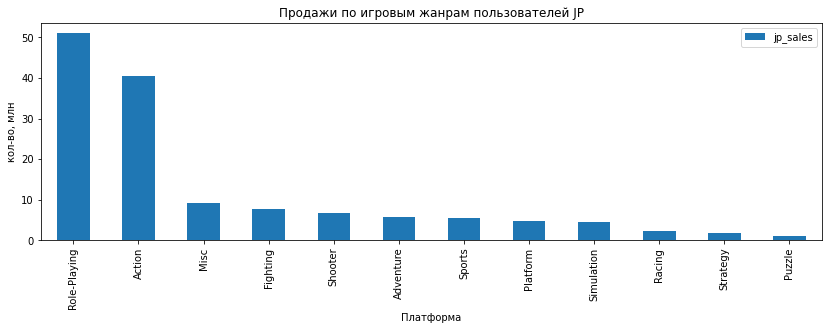

In [62]:
(df_query.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
 .sort_values(by='jp_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по игровым жанрам пользователей JP')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Спрос по жанрам в Японии так же отличается от других регионов, в топе Role-Playing, Action, Misc, Fighting, Shooter. При этом после жанра Action остальны примерно в равных долях.

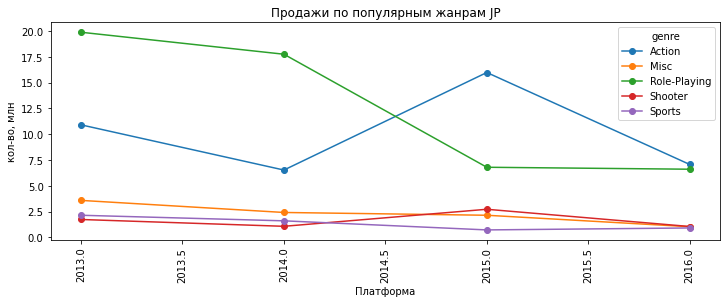

In [63]:
# построим график продаж в разрезе самых популярных жанров
(df_query.pivot_table(index=df_query.query('genre in ["Action", "Shooter", "Sports", "Role-Playing", "Misc"]')['genre']
                      , columns='year_of_release', values='jp_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по популярным жанрам JP')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Жанры Role-Playing, Action так же оставляют за собой лидирующие позиции в 2016 году, при этом Action немного впереди.

Отразим продажи исходя из рейтинга ESRB в Японии через график.

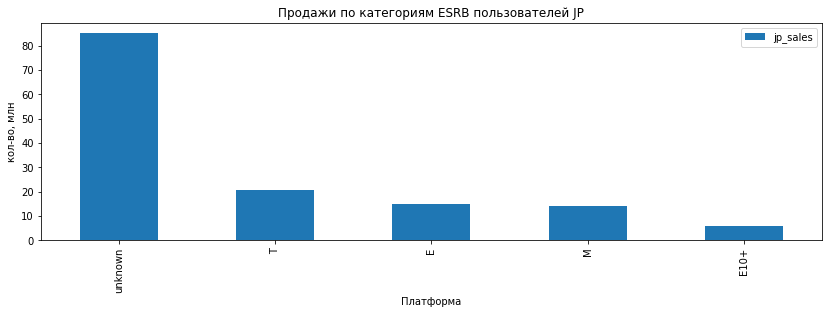

In [64]:
(df_query.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
 .sort_values(by='jp_sales', ascending=False)
 .plot(kind='bar', figsize=(14,4), rot=90)
)
plt.title('Продажи по категориям ESRB пользователей JP')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Доля продаж выше у категорий игр без категорий. 

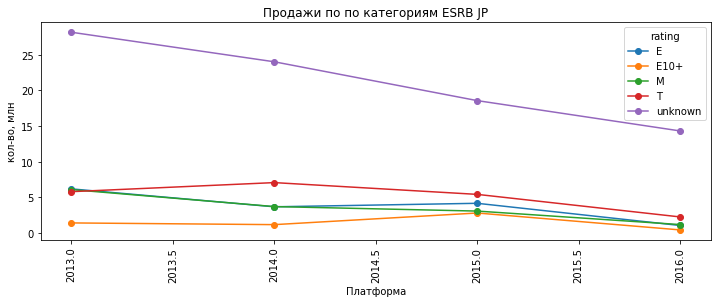

In [65]:
# построим график продаж в разрезе самых популярных жанров
(df_query.pivot_table(index='rating'
                      , columns='year_of_release', values='jp_sales', aggfunc='sum')
 .T
 .plot(kind='line', style='-o', figsize=(12,4), rot=90)
)
plt.title('Продажи по по категориям ESRB JP')
plt.xlabel('Платформа')
plt.ylabel('кол-во, млн');

Спрос на игры без категорий снижается так же как и в остальных случаях.

### Вывод

Северная Америка:
* В топ-5 попали платформы PS4, XOne, X360, PS3 и 3DS.
* В топ попали те же жанры, что и в общем анализе данных Action, Shooter, Sports, Role-Playing, Misc.
* Жанр Shooter так же начинает пользоваться большей популярностью среди пользователей Северной Америки. Наблюдался незначительный рост по продажам жанра Role-Playing в 2015.
* Доля продаж выше у категорий игр "Для взрослых", на втором месте игры без рейтинга. Поведение в 2016 году меняется, есть резкое снижение спроса на категорию игр "Для взрослых" и для игр, у которых не определена категория.

Европа:
* В топ-5 попали платформы PS4 и XOne они имеют более стабильные продажи, учитывая, что продажи в 2016 году на игры снизились, так же в топе PS3, X360 и 3DS с нисходящим трендом.
* В топ попали те же жанры, что и в общем анализе данных Action, Shooter, Sports, Role-Playing, Racing. На пятом месте по вкусовым предпочтениям Европейцев есть отличие. 
* Жанр Shooter так же начинает пользоваться большей популярностью среди пользователей Европы, более того в 2016 году набирает популярность жанр Sports.
* Доля продаж выше у категорий игр "Для взрослых", на втором месте игры c категрией для всех. Спрос на игры категории "Для подростков" (T) занимает более стабильные позиции, остальные категории игр теряют в объеме продаж.

Япония:
* В топ-5 попали платформы 3DS (с большим отрывом), PS3, PSV, PS4 и WiiU. Топ платформ в Японии разительно отличается от Европы и Северной Америки. При этом тренд нисходящий у 3DS, наблюдается рост продаж на платформе PS4.
* Спрос по жанрам в Японии так же отличается от других регионов, в топе Role-Playing, Action, Misc, Fighting, Shooter. При этом после жанра Action остальны примерно в равных долях.
* Жанры Role-Playing, Action так же оставляют за собой лидирующие позиции в 2016 году, при этом Action немного впереди.
* Доля продаж выше у категорий игр без категорий и спрос снижается так же как и в остальных случаях.

## Шаг 5. Проверка гипотез

Вычислим вероятность того, что две выбранные платформы дадут значение критерия большее или равное тому, которое мы получили. Эта вероятность называется p-value уровнем значимости. Если p-уровень значимости меньше 5 % (запишем, как 0,05), то нулевая гипотеза отвергается и принимается гипотеза о том, что выборки все-таки различаются. Если же p-уровень значимости больше 0,05, то нулевая гипотеза не отвергается. Однако то, что она не отвергается, еще не значит, что она верна. Это означает только то, что в данном опыте мы не обнаружили значимых различий.

**Гипотеза 1**  
Требуется проверить есть ли различия в среднем пользовательском рейтинге различия у платформ Xbox One и PC. Сформулируем нулевую и альтернативную гипотезы.

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
H1: Средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [66]:
df_query['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

In [67]:
# укажем уровень значимости
alpha = .05

In [68]:
# создадим отдельные сэмплы по условиям из гипотезы.
df_1 = df_query.query('platform == "XOne" and user_score < 555')['user_score']
df_2 = df_query.query('platform == "PC" and user_score < 555')['user_score']

# выборки разного размера и можно предположить, что дисперсии у генеральных совокупностей разные — укажем equal_var
_, pval = ttest_ind(df_1, df_2, equal_var = False)
print('p-value=%.3f' % pval)

# условие для проверки гипотезы
if pval > alpha:
    print('Не отвергаем гипотезу H0')
else:
    print('Отвергаем гипотезу H0')

p-value=0.148
Не отвергаем гипотезу H0


In [69]:
xone_mean = df_query.query('platform == "XOne" and user_score < 555')['user_score'].mean().round(2)
pc_mean = df_query.query('platform == "PC" and user_score < 555')['user_score'].mean().round(2)
   
print('Средний рейтинг пользователей «XOne»', xone_mean)
print('Средний рейтинг пользователей «PC»', pc_mean)

Средний рейтинг пользователей «XOne» 6.52
Средний рейтинг пользователей «PC» 6.27


**Интерпретация результата:**  
Полученное значение p-value (0,148) говорит о том, что средний рейтинг пришедший из Xbox One и PC неодинаков с вероятностью в почти 14,8%. Такую или большую разницу можно получить **случайно**, это большая вероятность, чтобы делать вывод о значимом различии между выборками.  
Данные предоставляют достаточное основание — для выбранного уровня значимости — не отвергать нулевую гипотезу. Значит, можно сделать вывод, что средние пользовательские рейтинги Xbox One и PC одинаковые.

**Гипотеза 2**  
Требуется проверить есть ли различия в среднем пользовательском рейтинге различия у жанров Action и Sports. Сформулируем нулевую и альтернативную гипотезы.

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.  
H1: Средние пользовательские рейтинги жанров Action и Sports не равны.

In [70]:
# создадим отдельные сэмплы по условиям из гипотезы.
df_1 = df_query.query('genre == "Action" and user_score < 555')['user_score']
df_2 = df_query.query('genre == "Sports" and user_score < 555')['user_score']

# выборки разного размера и можно предположить, что дисперсии у генеральных совокупностей разные — укажем equal_var
_, pval = ttest_ind(df_1, df_2, equal_var = False)
print('p-value=%.3f' % pval)

# условие для проверки гипотезы
if pval > alpha:
    print('Не отвергаем гипотезу H0')
else:
    print('Отвергаем гипотезу H0')

p-value=0.000
Отвергаем гипотезу H0


In [71]:
action_mean = df_query.query('genre == "Action" and user_score < 555')['user_score'].mean().round()
sports_mean = df_query.query('genre == "Sports" and user_score < 555')['user_score'].mean().round()
   
print('Средний рейтинг пользователей «XOne»', action_mean)
print('Средний рейтинг пользователей «PC»', sports_mean)

Средний рейтинг пользователей «XOne» 7.0
Средний рейтинг пользователей «PC» 5.0


**Интерпретация результата:**  
Полученное значение p-value (0,000) говорит о том, что средний рейтинг пришедший с разных жанров не одинаков. С вероятностью в 0% маленькую разницу можно получить случайно. Это сильно низкая вероятность, чтобы делать вывод об отсутствии различия между средними рейтингами.  
Данные предоставляют достаточное основание — для выбранного уровня значимости — отвергать нулевую гипотезу. Значит, можно сделать вывод, что средние пользовательские рейтинги Action и Sports не равны.

## Шаг 6. Общий вывод

* Были пропуски в данных, в столбцах: Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating. Всю подготовку данных провели. Заменили пропуски, где это было уместно, изменили название столбцов, привели к нужному формату данные.
* Поле year_of_release имел тип данных float64, преобразовали в тип datetime64.  
* Поле user_score имеет минимальный бал 0. Значение равные tbd - аббревиатура To Be Determined, т.е. "Будет определено". Рейтинг равный tbd, говорит о том, что он еще не определен. Nan занимает 40% объема данных. Числовые данные требовалось преобразовать из текста в float. Чтобы не навредить заменой пропущенных данных (т.к. мы достоверно не знаем, почему есть пропуски и зачем используется tbd) заменили tbd на 555, а nan на 999, после чего преобразовали колонку в тип float32.
* Явных и неявных дублей обнаружено не было.
* В поле rating есть значения NaN, так же можно предположить, что nan = «RP», «Рейтинг ожидается». Но организация ESRB появилась в 1994 году и игры появившиеся до 1994 не имеют рейтинга. Обычно этот рейтинг никто не хочет получить, так как велика вероятность, что игра вообще не окупится. Причины тому, что три основных производителя консолей [Nintendo, Sony и Microsoft] не разрешают выпускать игры с рейтингом AO на своих системах, как и большинство розничных магазинов. Поэтому и есть пропуски.
* Пропуски в полях name, year_of_release, т.к. требуется ручная обработка.
* В поле critic_score пропущенные значения заменили на 999, как поступили с полем user_score.

* Пик продаж пришелся на 2008 год.
* Пик выпуска игр пришелся на 2008 год, далее наблюдается спад продаж. Рост производства игр начался с 1994 года.
* Популярностью пользуются 6 игровых платформ от компаний PlayStation, Xbox и Nintendo. В среднем платформа держится на рынке 10-11 лет.
* Продажи в целом с 2009 года пошли на убыль, и в анализируемом периоде так же идет спад продаж. Потенциально прибыльными платформами являются PlayStation (PS4), Xbox (XOne) и Nintendo (3DS).
* Оценки критиков, если и оказывают влияние на объем продаж PS4, то оно слишком мало. Мы не принимаем в расчет показатель коэф. корреляции от -0,5 до +0,5, т.к. данные значения показывают слабую линейную зависимость. При этом оценки пользователей совсем не оказывают влияние на объем продаж платформы. Такая же корреляция и по срезу с остальными платформаими.  
* Объем продаж игр в жанре Shooter выше и стабильнее. Можно сказать, что интерес пользователи больше будут проявлять к Shooter-играм и данный жанр выйдет в лидеры продаж, не мтоит упускать из виду и игры жанра Sports. Shooter-ы на платформах PlayStation предположительно будут пользоваться спросом в 2017. Учитывая, что платформа в среднем на рынке живет 10 лет, а PS4 появилась в 2013, то немаловероятно, что она просуществует до 2023 года и пик продаж по этой платформе как раз придется на 2017 год.

Портреты пользователей:

Северная Америка:
* В топ-5 попали платформы PS4, XOne, X360, PS3 и 3DS.
* В топ попали те же жанры, что и в общем анализе данных Action, Shooter, Sports, Role-Playing, Misc.
* Жанр Shooter так же начинает пользоваться большей популярностью среди пользователей Северной Америки. Наблюдался незначительный рост по продажам жанра Role-Playing в 2015.
* Доля продаж выше у категорий игр "Для взрослых", на втором месте игры без рейтинга. Поведение в 2016 году меняется, есть резкое снижение спроса на категорию игр "Для взрослых" и для игр, у которых не определена категория.

Европа:
* В топ-5 попали платформы PS4 и XOne они имеют более стабильные продажи, учитывая, что продажи в 2016 году на игры снизились, так же в топе PS3, X360 и 3DS с нисходящим трендом.
* В топ попали те же жанры, что и в общем анализе данных Action, Shooter, Sports, Role-Playing, Racing. На пятом месте по вкусовым предпочтениям Европейцев есть отличие. 
* Жанр Shooter так же начинает пользоваться большей популярностью среди пользователей Европы, более того в 2016 году набирает популярность жанр Sports.
* Доля продаж выше у категорий игр "Для взрослых", на втором месте игры c категрией для всех. Спрос на игры категории "Для подростков" (T) занимает более стабильные позиции, остальные категории игр теряют в объеме продаж.

Япония:
* В топ-5 попали платформы 3DS (с большим отрывом), PS3, PSV, PS4 и WiiU. Топ платформ в Японии разительно отличается от Европы и Северной Америки. При этом тренд нисходящий у 3DS, наблюдается рост продаж на платформе PS4.
* Спрос по жанрам в Японии так же отличается от других регионов, в топе Role-Playing, Action, Misc, Fighting, Shooter. При этом после жанра Action остальны примерно в равных долях.
* Жанры Role-Playing, Action так же оставляют за собой лидирующие позиции в 2016 году, при этом Action немного впереди.
* Доля продаж выше у категорий игр без категорий и спрос снижается так же как и в остальных случаях.

Результаты проверки гипотез:  
* Интерпретация результата проверки гипотезы 1: Полученное значение p-value (0,148) говорит о том, что средний рейтинг пришедший из Xbox One и PC неодинаков с вероятностью в почти 14,8%. Такую или большую разницу можно получить случайно, это большая вероятность, чтобы делать вывод о значимом различии между выборками. Данные предоставляют достаточное основание — для выбранного уровня значимости — не отвергать нулевую гипотезу. **Значит, можно сделать вывод, что средние пользовательские рейтинги Xbox One и PC одинаковые.**

* Интерпретация результата: Полученное значение p-value (0,000) говорит о том, что средний рейтинг пришедший с разных жанров не одинаков. С вероятностью в 0% маленькую разницу можно получить случайно. Это сильно низкая вероятность, чтобы делать вывод об отсутствии различия между средними рейтингами. Данные предоставляют достаточное основание — для выбранного уровня значимости — отвергать нулевую гипотезу. **Значит, можно сделать вывод, что средние пользовательские рейтинги Action и Sports не равны.**